# General approach
Given a start state and a goal, the section on problem solving introduces a simple and elegant method to find a path from the start to the goal state. I'll call this search1 as the framework can be generalised in a number of ways that we'll explore later.

The function takes 3 inputs:
- s0: an initial state
- successors: a function to generate new (action, state) pairs from a given state
- checkGoal: a function to return true if the goal state is reached

The function returns the path to the goal state, or an empty array if one does not exist. Depending on the size of the state space, and whether a goal state exists, the approach may continue until indefinitely or until the code crashes.

In [16]:
def search1(s0, successors, checkGoal):
    frontier = [[s0]]
    explored = set()
    explored.add(s0)
    while frontier:
        path = frontier.pop()
        state = path[-1]
        if checkGoal(state):
            return path
        for action, nextState in successors(state):
            if nextState not in explored:
                frontier.append(path + [action, nextState])
                explored.add(nextState)
    return []

We can apply this to the water jug problem from Die Hard 3: 
- given jugs of capacity 3 gallons and 5 gallons
- ...a fountain to fill the jugs up and to empty them
- ...how can we attain a jug with exactly 4 gallons?

The search function is very succinct, and for given problem we need to specify the three inputs. For the water jug problem we have....

In [17]:
# initial state is that both jugs are empty
# all states will be represented by a tuple
s0_wp = (0, 0)

# define successors as fill, empty, transfer
# abstract the specific capacities of the jugs
def successors_wp(state, capacity1, capacity2):
    v1 = state[0]
    v2 = state[1]
    v1Capacity = capacity1 - v1
    v2Capacity = capacity2 - v2
    return [('fill 1', (capacity1, v2)),
            ('fill 2', (v1, capacity2)),
            ('empty 1', (0, v2)),
            ('empty 2', (v1, 0)),
            ('transfer 1 -> 2', (v1 - min(v1, v2Capacity), v2 + min(v1, v2Capacity))),
            ('transfer 2 -> 1', (v1 + min(v1Capacity, v2), v2 - min(v1Capacity, v2)))]

# check for goal state
# can be in either jug
def checkGoal_wp(state, goal):
    return goal in state

Now test this with the search function. The successor and goal-check functions have been defined with parameters to generalise the probem. The search function expects a single state argument, so we apply partial function application to set the parameters.

In [18]:
from functools import partial

solution_wp = search1(s0 = s0_wp,
                      successors = partial(successors_wp, capacity1 = 3, capacity2 = 5),
                      checkGoal = partial(checkGoal_wp, goal = 4))
solution_wp

[(0, 0),
 'fill 2',
 (0, 5),
 'transfer 2 -> 1',
 (3, 2),
 'empty 1',
 (0, 2),
 'transfer 2 -> 1',
 (2, 0),
 'fill 2',
 (2, 5),
 'transfer 2 -> 1',
 (3, 4)]

# Visualising the solution
It's nice to visual what the solutions look like. It can give you more intuition vs. reading off a series of state-action sequences. It's also as instructive to see the path not taken as it is to see the path that gets you to the goal state.

Graphviz is a great tool for doing this; it lets you specify nodes and the connections between them (edges), and then sets the graph out visually. On Python you can access this via the graphviz package. It's pretty intuitive to use e.g. to set out a simple graph with 3 nodes....

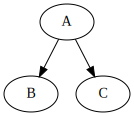

In [19]:
from graphviz import Digraph
dot = Digraph(comment = 'A graph')
dot.node('A')
dot.node('B')
dot.node('C')
dot.edge('A', 'B')
dot.edge('A', 'C')
dot

We define a new function, search2, that sets up a graph which is then returned alongside the path. The additional lines vs. search1 are commented.

In [20]:
def search2(s0, successors, checkGoal):
    dot = Digraph(comment = 'Problem solution')                      # initialize graph
    frontier = [[s0]]                           
    dot.node(str(s0))                                                # add initial state to graph
    explored = set()
    print(s0)
    explored.add(s0)
    while frontier:
        path = frontier.pop()
        state = path[-1]
        if checkGoal(state):
            dot.node(str(state), str(state) + '\nGOAL!')             # add goal label to node
            return (path, dot)                                       # return path and graph
        for action, nextState in successors(state):
            if nextState not in explored:
                dot.node(str(nextState))                             # add new node
                dot.edge(str(state), str(nextState), label=action)   # add edge between nodes
                frontier.append(path + [action, nextState])
                explored.add(nextState)
    return ([], dot)                                                 # return path and graph

We can apply this to the same probem and view the output path together with the graph. Note that since we add the nodes after we've checked if the next states exist in the explored set, the leaf nodes represent states from which no new states are reachable. If you move the code that adds the node and edge before the check, then you'll see all the moves, including the ones that lead to an existing explored state. 

(0, 0)
[(0, 0), 'fill 2', (0, 5), 'transfer 2 -> 1', (3, 2), 'empty 1', (0, 2), 'transfer 2 -> 1', (2, 0), 'fill 2', (2, 5), 'transfer 2 -> 1', (3, 4)]


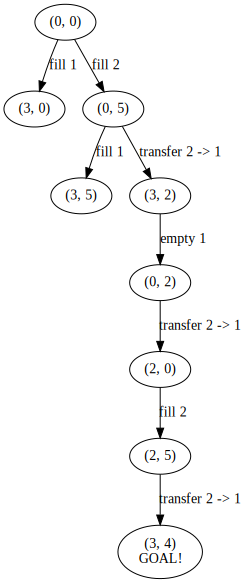

In [21]:
solution_wp = search2(s0 = s0_wp,
                      successors = partial(successors_wp, capacity1 = 3, capacity2 = 5),
                      checkGoal = partial(checkGoal_wp, goal = 4))
print(solution_wp[0])
solution_wp[1]

# Application to other problems 

## Route finding
The course looks at the following route-finding problem: you're in Romania, starting at Arad, and would like to get to Bucharest. You have the map that shows you how different cities are linked. To frame this as we did the water jug problem:
- we use the location of the current city as the state, so that in this case the initial state is 'Arad'
- we use the map below to define an adjency list that maps each city to every other city in can reach
- we use the destination city, in this case 'Bucharest', to test if we've reached our goal

Note that vs. the picture we end the network at Bucharest and do not include cities from that point.
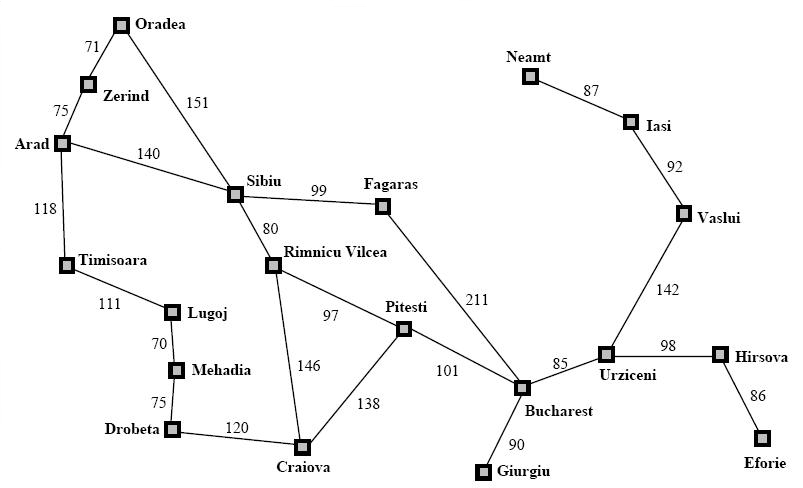

In [22]:
# initial state is current city, Arad
from functools import reduce

s0_rf = 'Arad'

# define successors as city A -> city B
# adjaceny list defined through dictionary
# define action label as empty string since label not required on graph


def successors_rf(state, citiesDict):
    nextStates = citiesDict[state]
    return [('', nstate) for nstate in nextStates]


# check for goal state


def checkGoal_rf(state, goalCity):
    return goalCity == state


citiesDict = \
    {'Arad': ['Zerind', 'Sibiu', 'Timisoara'],
     'Zerind': ['Arad', 'Oradea'],
     'Oradea': ['Zerind', 'Sibiu'],
     'Timisoara': ['Arad', 'Lugoj'],
     'Lugoj': ['Timisoara', 'Mehadia'],
     'Mehadia': ['Lugoj', 'Drobeta'],
     'Drobeta': ['Mehadia', 'Craiova'],
     'Sibiu': ['Arad', 'Oradea', 'Fagaras', 'Rimnicu Vilcea'],
     'Rimnicu Vilcea': ['Sibiu', 'Pitesti', 'Craiova'],
     'Craiova': ['Drobeta', 'Rimnicu Vilcea', 'Pitesti'],
     'Fagaras': ['Sibiu', 'Bucharest'],
     'Pitesti': ['Craiova', 'Rimnicu Vilcea', 'Bucharest'],
     'Bucharest': ['Pitesti', 'Fagaras']}

# sense-check the adjacency list is correct i.e. no typos
# pull out all the destinations
set(reduce(lambda l1, l2: l1 + l2, [citiesDict[x] for x in citiesDict]))

{'Arad',
 'Bucharest',
 'Craiova',
 'Drobeta',
 'Fagaras',
 'Lugoj',
 'Mehadia',
 'Oradea',
 'Pitesti',
 'Rimnicu Vilcea',
 'Sibiu',
 'Timisoara',
 'Zerind'}

Now apply solve2 as we did for the water jug probem.

Arad
['Arad', '', 'Timisoara', '', 'Lugoj', '', 'Mehadia', '', 'Drobeta', '', 'Craiova', '', 'Pitesti', '', 'Bucharest']


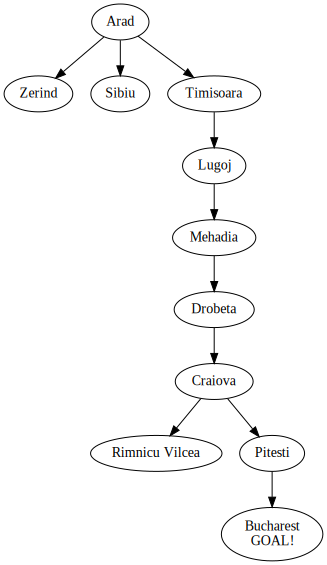

In [23]:
solution_rf = search2(s0 = s0_rf,
                      successors = partial(successors_rf, citiesDict = citiesDict),
                      checkGoal = partial(checkGoal_rf, goalCity = 'Bucharest'))
print(solution_rf[0])
solution_rf[1]

# Depth-first vs. breadth-first search

- clear from the existing searches that we're not always finding the shortest route
- that is, the shortest number of actions from the initial state to the goal state
- illustrate this with the route-finding problem
- from the map we can see that you can go from Arad to Bucharest in as little as 3 steps, though the current route takes seven steps
- the reason for this is the order in which the frontier is explored

- dfs vs. bfs
- updated search function, search3, adds a couple of features:
    - the node labels are appended with the order in which the states are added to the frontier
    - the frontier is optionally sorted
    

In [24]:
def search3(s0, successors, checkGoal, sortPaths = False):
    dot = Digraph(comment = 'Problem solution')                      
    nodeCount = 0
    frontier = [[s0]]                           
    dot.node(str(s0), str(s0) + '\n' + str(nodeCount))   
    nodeCount = nodeCount + 1
    explored = set()
    explored.add(s0)
    while frontier:
        path = frontier.pop()
        state = path[-1]
        if checkGoal(state):
            dot.node(str(state), str(state) + '\nGOAL!')             
            return (path, dot)                                       
        for action, nextState in successors(state):
            if nextState not in explored:
                dot.node(str(nextState), str(nextState) + '\n' + str(nodeCount)) 
                nodeCount = nodeCount + 1
                dot.edge(str(state), str(nextState), label=action)   
                frontier.append(path + [action, nextState])
                explored.add(nextState)
        if sortPaths:
            frontier.sort(key=len, reverse=True)        # sort frontier so that shortest paths are popped first
    print(explored)
    return ([], dot)                                                 

['Arad', '', 'Timisoara', '', 'Lugoj', '', 'Mehadia', '', 'Drobeta', '', 'Craiova', '', 'Pitesti', '', 'Bucharest']


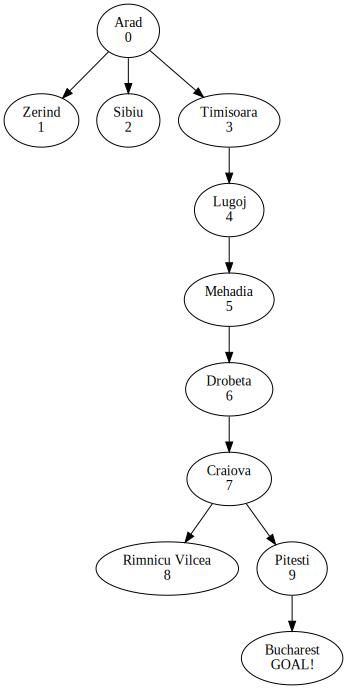

In [25]:
solution_rf = search3(s0 = s0_rf,
                      successors = partial(successors_rf, citiesDict = citiesDict),
                      checkGoal = partial(checkGoal_rf, goalCity = 'Bucharest'),
                      sortPaths = False)
print(solution_rf[0])
solution_rf[1]

# Weighted graphs

- thus far the search algorithms have been based solely on connections
- the bfs algorithm will find the shortest path in terms of how many steps
- .....but in reality what may also matter is the cost for an individual step
- in the route mapper example this is the distance between towns; we may prefer to drive 200 miles with 4 stops than 400 miles with 2 stops
